In [154]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [155]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 15000


In [198]:

sentences = []
labels = []
import re
def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text


import pandas as pd

df1 = pd.read_csv('/content/datos.csv')
df2 = pd.read_csv('/content/limpio.csv')
df2 = df2.drop(['Unnamed: 2'], axis=1)
df3 = pd.concat([df1,df2],ignore_index=True)
df4 = df3.dropna()

df5 = df4.drop(df4.index[19929])
df5['dato'] = df5['dato'].astype(str)
df5['etiqueta'] = df5['etiqueta'].apply(clean_text)

for string in df5['dato'].values:
    sentences.append(string)
for etiqueta in df5['etiqueta'].values:
    labels.append(int(etiqueta))
df5.shape

(20466, 2)

In [184]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2)

training_sentences = X_train
testing_sentences = X_test
training_labels = y_train
testing_labels = y_test

In [185]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [186]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [187]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [188]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 24)                408       
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [189]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
512/512 - 17s - loss: 0.6453 - accuracy: 0.6230 - val_loss: 0.5769 - val_accuracy: 0.6781 - 17s/epoch - 33ms/step
Epoch 2/30
512/512 - 3s - loss: 0.4138 - accuracy: 0.8257 - val_loss: 0.2832 - val_accuracy: 0.9018 - 3s/epoch - 6ms/step
Epoch 3/30
512/512 - 3s - loss: 0.2197 - accuracy: 0.9188 - val_loss: 0.2046 - val_accuracy: 0.9106 - 3s/epoch - 6ms/step
Epoch 4/30
512/512 - 3s - loss: 0.1675 - accuracy: 0.9314 - val_loss: 0.1828 - val_accuracy: 0.9167 - 3s/epoch - 6ms/step
Epoch 5/30
512/512 - 3s - loss: 0.1446 - accuracy: 0.9417 - val_loss: 0.1831 - val_accuracy: 0.9189 - 3s/epoch - 6ms/step
Epoch 6/30
512/512 - 3s - loss: 0.1302 - accuracy: 0.9484 - val_loss: 0.1688 - val_accuracy: 0.9196 - 3s/epoch - 6ms/step
Epoch 7/30
512/512 - 3s - loss: 0.1187 - accuracy: 0.9544 - val_loss: 0.1664 - val_accuracy: 0.9211 - 3s/epoch - 5ms/step
Epoch 8/30
512/512 - 3s - loss: 0.1089 - accuracy: 0.9602 - val_loss: 0.1662 - val_accuracy: 0.9204 - 3s/epoch - 5ms/step
Epoch 9/30
512/512 - 

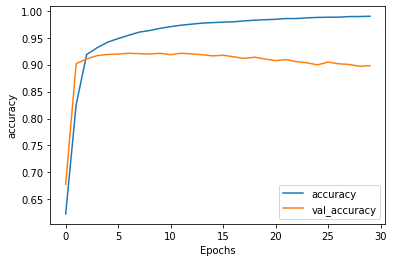

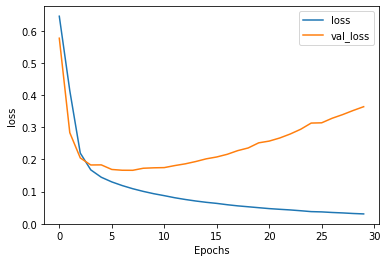

In [190]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [191]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

la vida por la gorda los quiero no se separen que estoy dejando hasta mi futura <OOV> aca gracias ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
oleada ramos muerete es más conciliador
1


In [192]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [193]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

In [195]:
sentence = ["eres fea y gorda", "me gustas y eres hermosa"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.9186112 ]
 [0.03142057]]


In [201]:
# Guardar el Modelo
model.save('path_to_my_model.h5')

from tensorflow import keras
# Recrea exactamente el mismo modelo solo desde el archivo
new_model = keras.models.load_model('path_to_my_model.h5')